In [208]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output

In [209]:
# Load data
df = pd.read_csv('stock_data.csv')

# Add moving averages (e.g., 5-day and 20-day)
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# Add Relative Strength Index (RSI)
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))
df['RSI'] = rsi

# Drop rows with missing values created by rolling calculations
df.dropna(inplace=True)

# Define relevant features
features = ['Volume', 'MA5', 'MA20', 'RSI']

# Normalize numerical features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
df[features] = scaled_features

# Save the preprocessed data back to CSV if needed
df.to_csv('preprocessed_stock_data.csv', index=False)

In [210]:
# Split data into features and target variable
X = df[features]
y = df['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model and scaler
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Make predictions on test data
y_pred = model.predict(X_test)

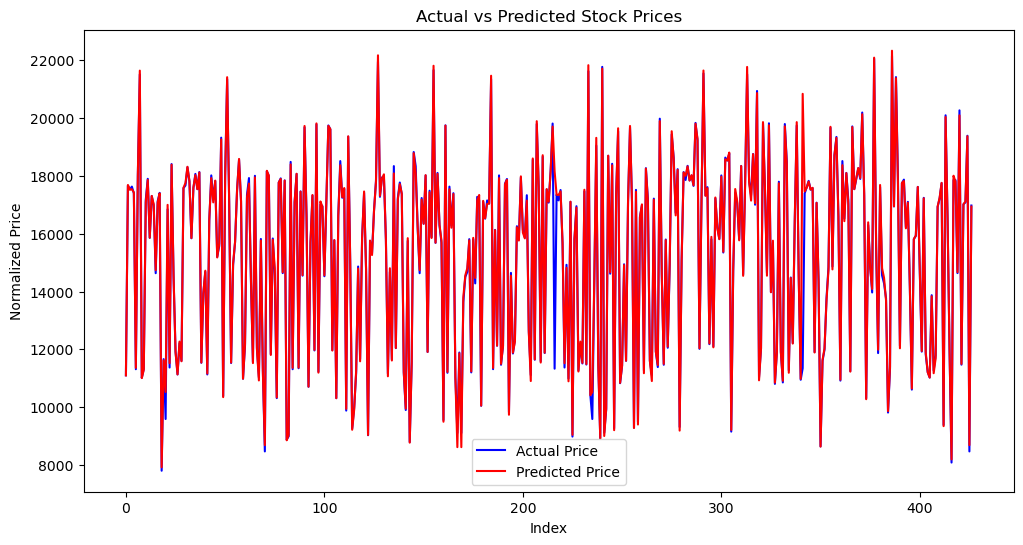

In [211]:
# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [212]:
# Load the trained model and scaler
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')

# Load preprocessed data for visualization
df = pd.read_csv('preprocessed_stock_data.csv')

# Define relevant features for scaling
features_for_scaling = ['Volume', 'MA5', 'MA20', 'RSI']

# def predict_stock_price(volume, ma5, ma20, rsi):
#     # Scale user inputs
#     input_data = [[volume, ma5, ma20, rsi]]
#     scaled_input = scaler.transform(input_data)

#     # Make prediction using the loaded model
#     predicted_price = model.predict(scaled_input)
#     #print (predicted_price)
#     return (predicted_price)

def predict_stock_price(volume, ma5, ma20, rsi):
    # Create a 2D array for input data
    input_data = [[volume, ma5, ma20, rsi]]

    # Scale the input data using the loaded scaler
    scaled_input = scaler.transform(input_data)

    # Make prediction using the loaded model
    predicted_price = model.predict(scaled_input)

    # Convert the predicted_price to a float
    predicted_price = float(predicted_price[0])  # Assuming the prediction is a single value

    return predicted_price



In [213]:
# Create input widgets
volume_widget = widgets.FloatText(value=1000000, description='Volume:')
ma5_widget = widgets.FloatText(value=150.0, description='MA5:')
ma20_widget = widgets.FloatText(value=145.0, description='MA20:')
rsi_widget = widgets.FloatText(value=70.0, description='RSI:')
predict_button = widgets.Button(description='Predicted')
output = widgets.Output()

In [214]:
def plot_actual_vs_predicted(volume, ma5, ma20, rsi):
    # Make prediction using the input values
    predicted_price = predict_stock_price(volume, ma5, ma20, rsi)

    with output:
        clear_output()
        print(f'Predicted Price: ${predicted_price:.2f}')

        # Plot actual vs predicted stock prices
        df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame

        # Create a new DataFrame row with the input values and predicted price
        new_row = pd.DataFrame([[volume, ma5, ma20, rsi, predicted_price]], columns=features_for_scaling + ['Predicted'])
        
        # Concatenate the new row to the DataFrame for plotting
        df_copy = pd.concat([df_copy, new_row], ignore_index=True)

        # Plot actual vs predicted stock prices
        plt.figure(figsize=(12, 6))
        plt.plot(df_copy.index, df_copy['Close'], label='Actual Price', color='blue')

        # Plot the predicted prices as a line
        plt.plot(df_copy.index, df_copy['Predicted'], marker='o', color='red', label='Predicted Price')

        # Add a line connecting the last actual price and the predicted price
        plt.plot([df_copy.index[-2], df_copy.index[-1]], [df_copy['Close'].iloc[-1], df_copy['Predicted'].iloc[-1]], linestyle='--', color='green', label='Prediction Line')
        
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Index')
        plt.ylabel('Normalized Price')
        plt.legend()
        
        # Show the plot with both actual and predicted prices
        plt.show()


In [215]:
# Define button click event handler
def on_predict_button_clicked(b):
    volume = volume_widget.value
    ma5 = ma5_widget.value
    ma20 = ma20_widget.value
    rsi = rsi_widget.value
    plot_actual_vs_predicted(volume, ma5, ma20, rsi)

# Assign the event handler to the button
predict_button.on_click(on_predict_button_clicked)

# Display the widgets
display(widgets.VBox([volume_widget, ma5_widget, ma20_widget, rsi_widget, predict_button]), output)

Output()

In [216]:
def plot_actual_vs_predicted(volume, ma5, ma20, rsi):
    # Make prediction using the input values
    predicted_price = predict_stock_price(volume, ma5, ma20, rsi)

    with output:
        clear_output()
        print(f'Predicted Price: ${predicted_price:.2f}')

        # Plot actual vs predicted stock prices
        df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame

        # Create a new DataFrame row with the input values and predicted price
        new_row = pd.DataFrame([[volume, ma5, ma20, rsi, predicted_price]], columns=features_for_scaling + ['Predicted'])
        
        # Concatenate the new row to the DataFrame for plotting
        df_copy = pd.concat([df_copy, new_row], ignore_index=True)

        # Plot actual vs predicted stock prices
        plt.figure(figsize=(12, 6))
        plt.plot(df_copy.index, df_copy['Close'], label='Actual Price', color='blue')

        # Plot the predicted price
        plt.plot(df_copy.index[-1], df_copy['Predicted'].iloc[-1], marker='o', color='red', label='Predicted Price')

        # Add a line connecting the last actual price and the predicted price
        plt.plot([df_copy.index[-2], df_copy.index[-1]], [df_copy['Close'].iloc[-1], df_copy['Predicted'].iloc[-1]], linestyle='--', color='green', label='Prediction Line')
        
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Index')
        plt.ylabel('Normalized Price')
        plt.legend()
        
        # Show the plot with both actual and predicted prices
        plt.show()
